# Activity 3 Naive Bayes

<img src="./tec_logo.png" width="auto" height="200" />

**Marcos Dayan Mann**

A01782876

Deliver date: September 9th, 2025

# # Introduction

In this notebook, I implemented a Naive Bayes text classifier for the X dataset with three classes: positive, negative, and neutral.
My solution will do the following:

- Adapt Naive Bayes to multiple classes.
- Use Bag of Wordsfor encoding the text into vectors
- Train/evaluate with feature sizes: 20, 40, 60, 80, 100, 120 (top most frequent tokens).
- Perform K‑Fold Cross‑Validation for K with values {3, 4, 5, 6}.
- Compute macro-precision, macro-recall, macro-F1, and accuracy.
- Provide six visualizations to understand behavior across settings.
- Compare manual implementation vs scikit-learn.
- Provide a brief conclusion.

In [1]:
base_path = "dataset/"

import os

train_file = os.path.join(base_path, "training.txt")
test_file  = os.path.join(base_path, "test.txt")

if not (os.path.exists(train_file) and os.path.exists(test_file)):
    print("WARNING: training.txt and/or test.txt not found in:", base_path)



# Loading, Vocabulary, and Vectorization with bag of worda

In [2]:

import codecs
import operator
from collections import Counter, defaultdict

def load_labeled_lines(path):
    """
    Load lines in the 'text @@@ label' format.
    Returns: list of (tokens_list, label)
    """
    samples = []
    with codecs.open(path, "r", "UTF-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split("@@@")
            if len(parts) != 2:
                continue
            text, label = parts[0].strip(), parts[1].strip()
            tokens = text.split()
            samples.append((tokens, label))
    return samples

def build_vocabulary(training_samples):
    """
    Build token frequency dictionary from training samples.
    Returns a list of tokens sorted by global frequency (desc).
    """
    vocab_counter = Counter()
    for tokens, _ in training_samples:
        vocab_counter.update(tokens)
    sorted_vocab = sorted(vocab_counter.items(), key=lambda kv: (-kv[1], kv[0]))
    return [tok for tok, cnt in sorted_vocab]

def vectorize_bow(samples, features):
    """
    Convert samples to Bag-of-Words count vectors given a 'features' list (top-N tokens).
    Returns X (list of lists) and y (labels).
    """
    idx = {tok: i for i, tok in enumerate(features)}
    X = []
    y = []
    for tokens, label in samples:
        counts = Counter(tokens)
        vec = [0]*len(features)
        for t, c in counts.items():
            if t in idx:
                vec[idx[t]] = c  # frequency count
        X.append(vec)
        y.append(label)
    return X, y


## 3.1 Load Dataset

In [3]:
train_samples = load_labeled_lines(train_file)
test_samples  = load_labeled_lines(test_file)

print(f"Train samples: {len(train_samples)} | Test samples: {len(test_samples)}")
labels_set = sorted({lab for _, lab in train_samples})
print("Detected classes:", labels_set)


Train samples: 4187 | Test samples: 867
Detected classes: ['c', 'negative', 'neutral', 'positive']


## 3.2 Feature Selection (Top-N) and BOW Vectors

## Build global vocabulary from training set

In [4]:
vocabulary = build_vocabulary(train_samples)
print("Top 10 tokens in vocabulary:", vocabulary[:10])

def make_vectors(topN):
    features = vocabulary[:topN]
    X_train, y_train = vectorize_bow(train_samples, features)
    X_test,  y_test  = vectorize_bow(test_samples, features)
    return features, X_train, y_train, X_test, y_test

_ = make_vectors(40)

Top 10 tokens in vocabulary: ['the', 'to', 'in', 'on', 'a', 'and', 'i', 'of', 'for', 'is']



# Manual Naive Bayes wirh bag of words

In [7]:

import math
from collections import Counter
import numpy as np

def train_naive_bayes_multiclass(X, y, alpha=1.0):
    """
    Train the model

    Used ChatGPT5 in order to implement the algorithm with optimal settings
    """
    n_docs = len(X)
    n_features = len(X[0]) if X else 0
    classes = sorted(set(y))

    class_counts = Counter(y)
    priors_log = {c: math.log(class_counts[c] / n_docs) for c in classes}

    feature_counts_per_class = {c: [0]*n_features for c in classes}
    total_counts_per_class = {c: 0 for c in classes}
    for vec, lab in zip(X, y):
        total_counts_per_class[lab] += sum(vec)
        fc = feature_counts_per_class[lab]
        for i, cnt in enumerate(vec):
            fc[i] += cnt

    cond_logprob = {c: [0]*n_features for c in classes}
    for c in classes:
        denom = total_counts_per_class[c] + alpha * n_features
        for i in range(n_features):
            num = feature_counts_per_class[c][i] + alpha
            cond_logprob[c][i] = math.log(num / denom)
    return {"classes": classes, "priors_log": priors_log, "cond_logprob": cond_logprob}

def predict_naive_bayes(model, X):
    classes = model["classes"]
    priors_log = model["priors_log"]
    cond_logprob = model["cond_logprob"]
    preds = []
    for vec in X:
        scores = {}
        for c in classes:
            s = priors_log[c]
            clp = cond_logprob[c]
            for i, cnt in enumerate(vec):
                if cnt:
                    s += cnt * clp[i]
            scores[c] = s

        pred = max(scores.items(), key=lambda kv: kv[1])[0]
        preds.append(pred)
    return preds



# Evaluation: Accuracy, Macro-Precision, Macro-Recall, Macro-F1 with K-Fold

In [11]:

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def evaluate_model_cv_manual(X, y, k=5, alpha=1.0, random_state=42):
    """
    K-Fold evaluation for the manual model.
    """
    X = np.array(X, dtype=object)
    y = np.array(y)
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    accs, precs, recs, f1s = [], [], [], []
    cm_sum = None
    classes = sorted(set(y))

    for train_idx, test_idx in kf.split(X):
        X_tr = [list(map(int, x)) for x in X[train_idx]]
        y_tr = list(y[train_idx])
        X_te = [list(map(int, x)) for x in X[test_idx]]
        y_te = list(y[test_idx])

        model = train_naive_bayes_multiclass(X_tr, y_tr, alpha=alpha)
        preds = predict_naive_bayes(model, X_te)

        accs.append(accuracy_score(y_te, preds))
        precs.append(precision_score(y_te, preds, average='macro', zero_division=0))
        recs.append(recall_score(y_te, preds, average='macro', zero_division=0))
        f1s.append(f1_score(y_te, preds, average='macro', zero_division=0))

        cm = confusion_matrix(y_te, preds, labels=classes)
        cm_sum = cm if cm_sum is None else cm_sum + cm

    results = {
        "classes": classes,
        "accuracy": np.array(accs),
        "precision_macro": np.array(precs),
        "recall_macro": np.array(recs),
        "f1_macro": np.array(f1s),
        "confusion_matrix_sum": cm_sum
    }
    return results

def manual_valuation(feature_grid=(20,40,60,80,100,120), k_grid=(3,4,5,6), alpha=1.0):
    """
    Run the required grid over feature sizes and K folds. Returns a list of dicts per run.
    """
    out = []
    for topN in feature_grid:
        features, X_train, y_train, _, _ = make_vectors(topN)
        for k in k_grid:
            res = evaluate_model_cv_manual(X_train, y_train, k=k, alpha=alpha)
            out.append({
                "topN": topN,
                "k": k,
                "acc_mean": float(res["accuracy"].mean()),
                "prec_mean": float(res["precision_macro"].mean()),
                "rec_mean": float(res["recall_macro"].mean()),
                "f1_mean": float(res["f1_macro"].mean()),
                "acc_std": float(res["accuracy"].std()),
                "prec_std": float(res["precision_macro"].std()),
                "rec_std": float(res["recall_macro"].std()),
                "f1_std": float(res["f1_macro"].std()),
            })
    return out


## 5.1 Run Experiments Grid (Manual NB)

In [12]:

import pandas as pd

manual_results = manual_valuation()
df_manual = pd.DataFrame(manual_results).sort_values(["topN","k"]).reset_index(drop=True)
df_manual


,topN,k,acc_mean,prec_mean,rec_mean,f1_mean,acc_std,prec_std,rec_std,f1_std
0,20,3,0.529735,0.369391,0.309403,0.235185,0.001926,0.083361,0.041257,0.028705
1,20,4,0.528780,0.355678,0.315614,0.239758,0.004984,0.068917,0.038178,0.024958
2,20,5,0.527822,0.356579,0.320054,0.245051,0.010707,0.049813,0.035384,0.025240
3,20,6,0.526632,0.329599,0.320809,0.242675,0.009729,0.071195,0.034624,0.027635
4,40,3,0.529497,0.379736,0.333727,0.293638,0.002660,0.065470,0.046405,0.043801
5,40,4,0.529496,0.392907,0.338982,0.296533,0.006146,0.070607,0.043390,0.036839
6,40,5,0.526388,0.389812,0.341503,0.298981,0.013026,0.060110,0.039075,0.032588
7,40,6,0.527110,0.396779,0.345789,0.302884,0.007504,0.052688,0.035245,0.028796
8,60,3,0.539290,0.413797,0.369232,0.354981,0.006439,0.058926,0.044195,0.042839
9,60,4,0.537859,0.417453,0.375282,0.359463,0.009221,0.047388,0.036100,0.031311


# Scikit-learn MultinomialNB Baseline and Cross-Validation

In [16]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate
import numpy as np
import pandas as pd

def sklearn_cv_for_grid(feature_grid=(20,40,60,80,100,120), k_grid=(3,4,5,6), alpha=1.0):
    rows = []
    for topN in feature_grid:
        features, X_train, y_train, _, _ = make_vectors(topN)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        for k in k_grid:
            model = MultinomialNB(alpha=alpha)
            scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
            cvres = cross_validate(model, X_train, y_train, cv=k, scoring=scoring, return_train_score=False)
            rows.append({
                "topN": topN,
                "k": k,
                "acc_mean": float(cvres['test_accuracy'].mean()),
                "prec_mean": float(cvres['test_precision_macro'].mean()),
                "rec_mean": float(cvres['test_recall_macro'].mean()),
                "f1_mean": float(cvres['test_f1_macro'].mean()),
                "acc_std": float(cvres['test_accuracy'].std()),
                "prec_std": float(cvres['test_precision_macro'].std()),
                "rec_std": float(cvres['test_recall_macro'].std()),
                "f1_std": float(cvres['test_f1_macro'].std()),
            })
    return pd.DataFrame(rows).sort_values(["topN","k"]).reset_index(drop=True)

df_skl = sklearn_cv_for_grid()
df_skl


/opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/lib/python3.13/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in lab

,topN,k,acc_mean,prec_mean,rec_mean,f1_mean,acc_std,prec_std,rec_std,f1_std
0,20,3,0.527346,0.340000,0.309376,0.238713,0.004179,0.031499,0.039214,0.025247
1,20,4,0.527346,0.364278,0.316948,0.245936,0.004656,0.053309,0.035690,0.022534
2,20,5,0.528778,0.360566,0.320030,0.244281,0.003314,0.055205,0.030247,0.018953
3,20,6,0.529496,0.373894,0.323891,0.248200,0.006029,0.070892,0.033240,0.026760
4,40,3,0.523523,0.360165,0.326751,0.285104,0.005261,0.027231,0.039760,0.032837
5,40,4,0.516596,0.352268,0.331360,0.291800,0.011149,0.038676,0.035230,0.029804
6,40,5,0.523527,0.388624,0.340254,0.297971,0.009897,0.075091,0.038537,0.031884
7,40,6,0.524717,0.382796,0.343719,0.301034,0.011427,0.062255,0.038388,0.037344
8,60,3,0.536421,0.406076,0.368229,0.355289,0.004370,0.048710,0.050895,0.051002
9,60,4,0.533315,0.415222,0.376639,0.365606,0.009299,0.053335,0.048196,0.049507


# Results Comparison — Manual vs Scikit‑learn

In [17]:

df_compare = (df_manual
              .merge(df_skl, on=["topN","k"], suffixes=("_manual","_skl")))
df_compare


,topN,k,acc_mean_manual,prec_mean_manual,rec_mean_manual,f1_mean_manual,acc_std_manual,prec_std_manual,rec_std_manual,f1_std_manual,acc_mean_skl,prec_mean_skl,rec_mean_skl,f1_mean_skl,acc_std_skl,prec_std_skl,rec_std_skl,f1_std_skl
0,20,3,0.529735,0.369391,0.309403,0.235185,0.001926,0.083361,0.041257,0.028705,0.527346,0.340000,0.309376,0.238713,0.004179,0.031499,0.039214,0.025247
1,20,4,0.528780,0.355678,0.315614,0.239758,0.004984,0.068917,0.038178,0.024958,0.527346,0.364278,0.316948,0.245936,0.004656,0.053309,0.035690,0.022534
2,20,5,0.527822,0.356579,0.320054,0.245051,0.010707,0.049813,0.035384,0.025240,0.528778,0.360566,0.320030,0.244281,0.003314,0.055205,0.030247,0.018953
3,20,6,0.526632,0.329599,0.320809,0.242675,0.009729,0.071195,0.034624,0.027635,0.529496,0.373894,0.323891,0.248200,0.006029,0.070892,0.033240,0.026760
4,40,3,0.529497,0.379736,0.333727,0.293638,0.002660,0.065470,0.046405,0.043801,0.523523,0.360165,0.326751,0.285104,0.005261,0.027231,0.039760,0.032837
5,40,4,0.529496,0.392907,0.338982,0.296533,0.006146,0.070607,0.043390,0.036839,0.516596,0.352268,0.331360,0.291800,0.011149,0.038676,0.035230,0.029804
6,40,5,0.526388,0.389812,0.341503,0.298981,0.013026,0.060110,0.039075,0.032588,0.523527,0.388624,0.340254,0.297971,0.009897,0.075091,0.038537,0.031884
7,40,6,0.527110,0.396779,0.345789,0.302884,0.007504,0.052688,0.035245,0.028796,0.524717,0.382796,0.343719,0.301034,0.011427,0.062255,0.038388,0.037344
8,60,3,0.539290,0.413797,0.369232,0.354981,0.006439,0.058926,0.044195,0.042839,0.536421,0.406076,0.368229,0.355289,0.004370,0.048710,0.050895,0.051002
9,60,4,0.537859,0.417453,0.375282,0.359463,0.009221,0.047388,0.036100,0.031311,0.533315,0.415222,0.376639,0.365606,0.009299,0.053335,0.048196,0.049507



# Visualizations

In [19]:
import plotly.express as px
import plotly.graph_objects as go

### a) F1 vs features for each K (manual)

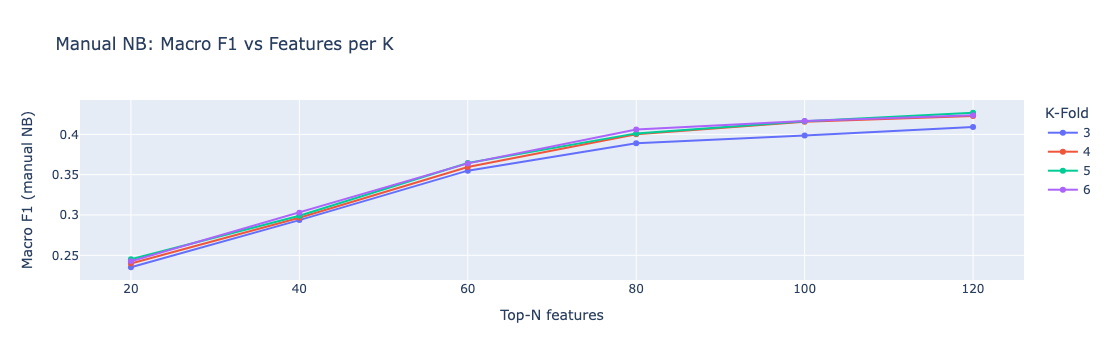

In [20]:
fig1 = px.line(df_manual, x="topN", y="f1_mean", color="k", markers=True,
               title="Manual NB: Macro F1 vs Features per K",
               labels={"topN": "Top-N features", "f1_mean": "Macro F1 (manual NB)", "k": "K-Fold"})
fig1.show()

### b) Accuracy vs features (sklearn)

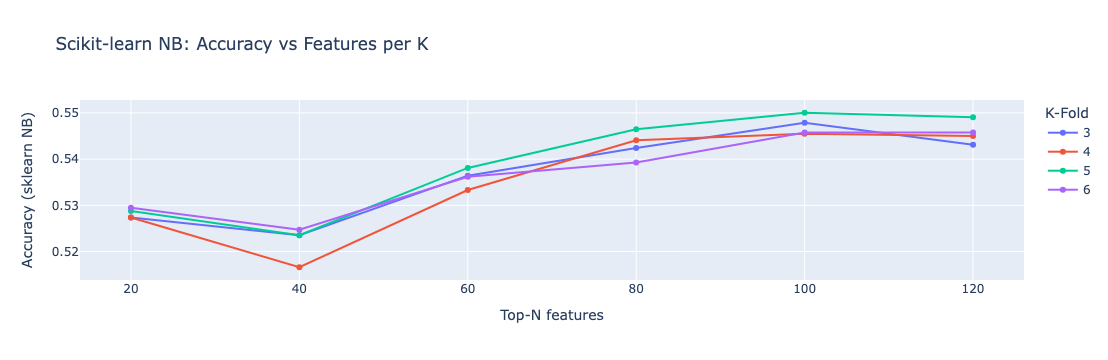

In [21]:
fig2 = px.line(df_skl, x="topN", y="acc_mean", color="k", markers=True,
               title="Scikit-learn NB: Accuracy vs Features per K",
               labels={"topN": "Top-N features", "acc_mean": "Accuracy (sklearn NB)", "k": "K-Fold"})
fig2.show()

### c) Manual vs sklearn F1 (grouped by features) for a fixed K=5

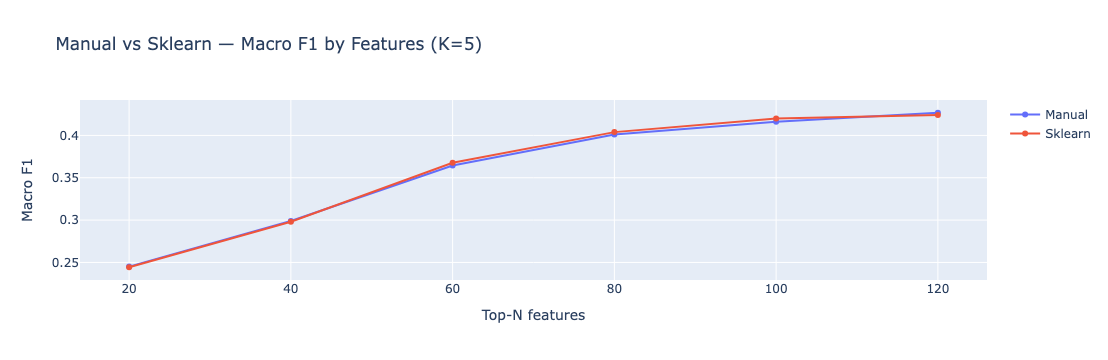

In [22]:
k_fixed = 5 if 5 in set(df_manual['k']) else sorted(df_manual['k'].unique())[0]
m_fixed = df_manual[df_manual['k']==k_fixed]
s_fixed = df_skl[df_skl['k']==k_fixed]

fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=m_fixed["topN"], y=m_fixed["f1_mean"], mode="lines+markers", name="Manual"))
fig3.add_trace(go.Scatter(x=s_fixed["topN"], y=s_fixed["f1_mean"], mode="lines+markers", name="Sklearn"))
fig3.update_layout(title=f"Manual vs Sklearn — Macro F1 by Features (K={k_fixed})",
                   xaxis_title="Top-N features", yaxis_title="Macro F1")
fig3.show()

### d) Macro Precision/Recall/F1 (manual) vs features (averaged over K)

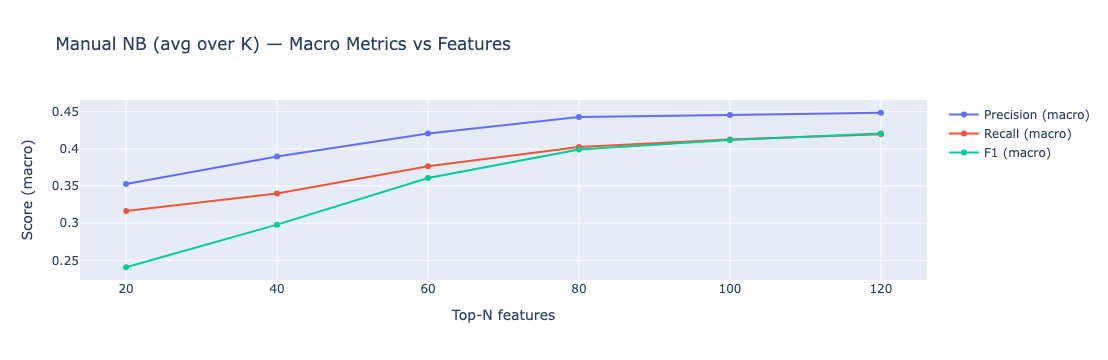

In [23]:
agg = df_manual.groupby('topN')[['prec_mean','rec_mean','f1_mean']].mean().reset_index()
fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=agg["topN"], y=agg["prec_mean"], mode="lines+markers", name="Precision (macro)"))
fig4.add_trace(go.Scatter(x=agg["topN"], y=agg["rec_mean"], mode="lines+markers", name="Recall (macro)"))
fig4.add_trace(go.Scatter(x=agg["topN"], y=agg["f1_mean"], mode="lines+markers", name="F1 (macro)"))
fig4.update_layout(title="Manual NB (avg over K) — Macro Metrics vs Features",
                   xaxis_title="Top-N features", yaxis_title="Score (macro)")
fig4.show()

### e) Best setting confusion matrix (manual)

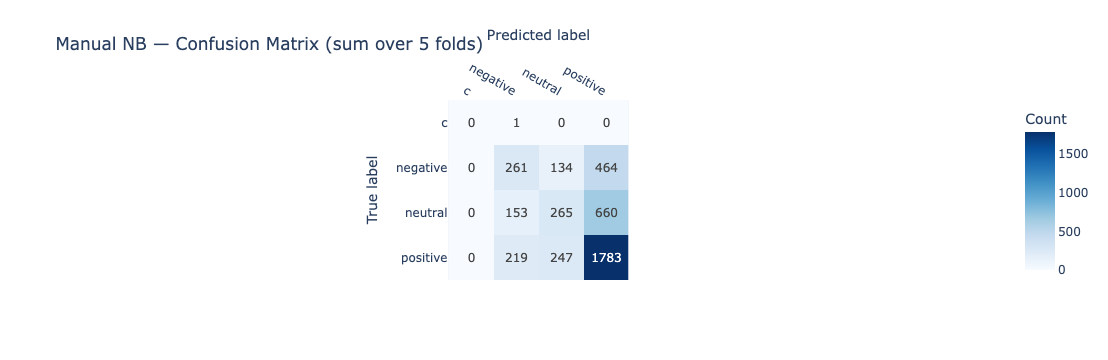

In [24]:
best_row = df_manual.iloc[df_manual['f1_mean'].idxmax()]
best_topN = int(best_row['topN']); best_k = int(best_row['k'])
features, X_train_full, y_train_full, _, _ = make_vectors(best_topN)
res_best = evaluate_model_cv_manual(X_train_full, y_train_full, k=best_k)
cm = res_best['confusion_matrix_sum']
classes = res_best['classes']

fig5 = px.imshow(cm, text_auto=True, color_continuous_scale="Blues",
                 x=classes, y=classes,
                 labels=dict(x="Predicted label", y="True label", color="Count"),
                 title=f"Manual NB — Confusion Matrix (sum over {best_k} folds)")
fig5.update_xaxes(side="top")
fig5.show()

### f) Stability (std) plot: F1 std vs features (manual)

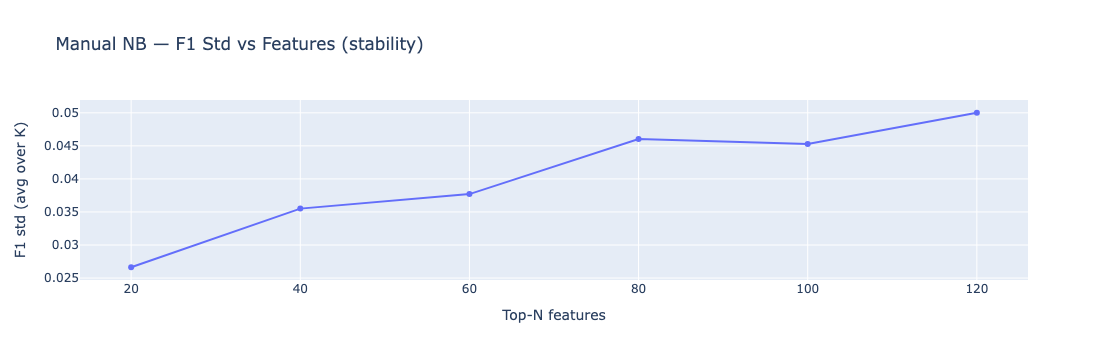

In [25]:
std_agg = df_manual.groupby('topN')['f1_std'].mean().reset_index()
fig6 = px.line(std_agg, x="topN", y="f1_std", markers=True,
               title="Manual NB — F1 Std vs Features (stability)",
               labels={"topN": "Top-N features", "f1_std": "F1 std (avg over K)"})
fig6.show()


# Findings and Conclussion

Through the model imlementation, I found out that this dataset alongside this Naive Bayes implementation was a complete failure. With b oth the manual model implementation and the sklearn one, I just got a maximum of 54% accuracy using Kfold cross validation, which is a total waste of time and resources. The model acts slightly better than tossing a dice for classifying the sentiment on the given texts.

What got my attention, is that even with the sklearn library, the model accuracy does not improve. 

I can conclude that the problem is the poor training a test data labeling. Inspecting the dataset manually, I found out that effectively the labeling is incongruent, and appears to be work of a randome classification, which explains a little bit the results I got

Even though the result I got are not good, with this activity I learned the basics of the Naive Bayes algorithm and its use cases in real life scenarios